In [25]:
import requests
import pandas as pd
from datetime import datetime

base = "https://fapi.binance.com"
params = {
    "symbol": "BTCUSDT",
    "startTime": int(datetime(2025, 3, 1).timestamp() * 1000),  # in ms
    "endTime": int(datetime(2026, 1, 14).timestamp() * 1000),    # in ms
    "limit": 1000
}
r = requests.get(f"{base}/fapi/v1/fundingRate", params=params)
data = r.json()

df = pd.DataFrame(data)

In [26]:
# Convert fundingTime to datetime and fundingRate to float
df['fundingTime'] = pd.to_datetime(df['fundingTime'], unit='ms')
df['fundingRate'] = df['fundingRate'].astype(float)

# Set fundingTime as index for resampling
df_daily = df.set_index('fundingTime').resample('D')['fundingRate'].mean().reset_index()

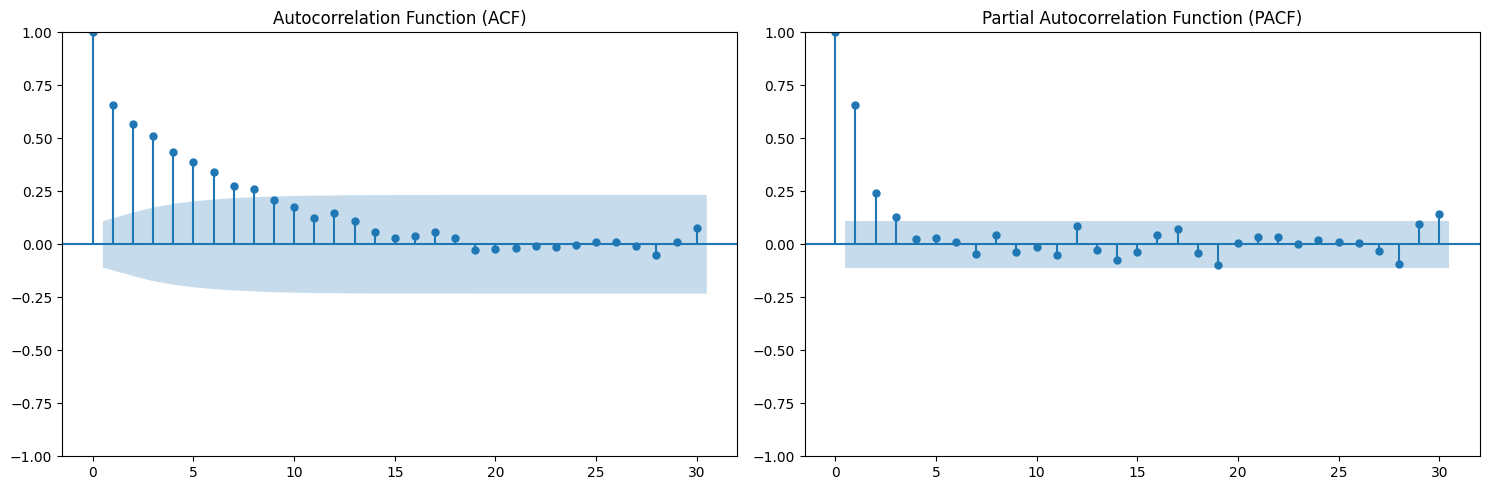

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

# Create subplots for ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF
plot_acf(df_daily['fundingRate'], lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(df_daily['fundingRate'], lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()